# Data Exploration

Setting up some basic packages for exploration.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

Reading in training and testing data. Mapping salary to binary value (this is what we want to predict).

In [12]:
from sklearn.model_selection import train_test_split
pd.options.mode.chained_assignment = None  # default='warn'
df = pd.read_csv("adult-data.csv")
train, test = train_test_split(df, test_size = 0.2, random_state = 42, shuffle = True)
train['income'] = train['income'].map({"<=50K":0, ">50K":1})
test['income'] = test['income'].map({"<=50K.":0, ">50K.":1})
# To binary mapping
train['race'] = train['race'].map({"Black": 0, "Other": 1, "Amer-Indian-Eskimo": 1, "Asian-Pac-Islander": 1, "White":1})
test['race'] = test['race'].map({"Black": 0, "Other": 1, "Amer-Indian-Eskimo": 1, "Asian-Pac-Islander": 1, "White":1})

Y = train['income']
Y_race = train['race']
X = train.drop(['income', 'fnlwgt', 'native.country', 'race'], axis = 1)
Y_test = test['income']
Y_test_race = test['race']
X_test = test.drop(['income', 'fnlwgt', 'native.country', 'race'], axis = 1)
X_test

,age,workclass,education,education.num,marital.status,occupation,relationship,sex,capital.gain,capital.loss,hours.per.week
14160,29,Private,Some-college,10,Married-civ-spouse,Handlers-cleaners,Husband,Male,0,0,40
27048,19,Private,Some-college,10,Never-married,Sales,Own-child,Male,0,0,15
28868,28,Private,Some-college,10,Married-civ-spouse,Tech-support,Wife,Female,0,0,40
5667,35,Private,11th,7,Never-married,Sales,Not-in-family,Male,0,0,45
7827,20,Private,Some-college,10,Never-married,Adm-clerical,Own-child,Female,0,0,30
...,...,...,...,...,...,...,...,...,...,...,...
1338,27,Self-emp-not-inc,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,Male,0,1573,70
24534,63,Private,HS-grad,9,Never-married,Exec-managerial,Not-in-family,Male,0,0,40
18080,56,Private,Masters,14,Married-civ-spouse,Prof-specialty,Husband,Male,0,0,40
10354,22,?,Assoc-voc,11,Never-married,?,Own-child,Male,0,0,20


Naive oversampling of our training data. This one of the mechanisms we will test to see its effect on bias. We simply oversample the minority class (black in this case) so that our classes are more balanced. We are going to resample based on some coefficient RESAMPLE_COEFFICIENT. If this is 1, we simple resample the total amount in the minority class. 

In [3]:
from keras.utils import to_categorical, plot_model

minority = train[train['race']== 0]
print(len(minority), len(train))
RESAMPLE_COEFFICIENT = 1.5
oversample = minority.sample(int(RESAMPLE_COEFFICIENT * len(minority)), replace = True, random_state = 1)
train_o = pd.concat([train, oversample], axis = 0)
##Perform similar X, Y split on train_o, the oversampled training data
Y_o_race = train_o['race']
Y_o = train_o['ann_salary']
X_o = train_o.drop(['ann_salary', 'fnlwgt', 'country', 'race'], axis = 1)

3124 32561


Some basic analysis of race groups above and below 50 K ("rich" and "poor")

In [4]:
total = train.groupby('race').size().reset_index()

rich = train[train['ann_salary'] == 1]
rich = rich.groupby('race').size().reset_index()
rich[0] = rich[0]/total[0]

poor = train[train['ann_salary'] == 0]
poor = poor.groupby('race').size().reset_index()
poor[0] = poor[0]/total[0]

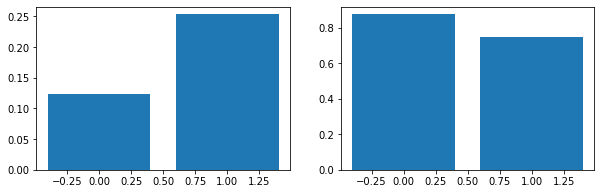

In [5]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(10,3)
ax1.bar(rich['race'], rich[0])
ax2.bar(poor['race'], poor[0])
plt.show()

We want to see what is the value of p in our training data, because it is likely that such a pattern will reveal itself in the model. In other words, what is the maximum bias that is shown in the data? This is assuming there are no confounding variables between race groups. 

In [6]:
#Proportion of black people who are rich. Dividing the "length" of the DFs of only >50k and the entire data, subsetting for black race
blackrich = len(rich[rich['race'] == 0])/len(train[train['race'] == 0])
#Same idea for other races
nonblackrich = len(rich[rich['race'] == 1])/len(train[train['race'] == 1])

More processing things, one-hot encoding categorical variables, making sure that the test and train have the same encodings, by using df.align on column case. Then, converting everything into numpy arrays. 

In [7]:

from keras import Sequential
from sklearn.preprocessing import OneHotEncoder

dumdf = pd.get_dummies(X, columns = ["workclass", "education", "education_num", "marital_status", "occupation", "relationship", "sex"], drop_first = True)
testdf = pd.get_dummies(X_test, columns = ["workclass", "education", "education_num", "marital_status", "occupation", "relationship", "sex"], drop_first = True)
dumdf_o = pd.get_dummies(X_o, columns = ["workclass", "education", "education_num", "marital_status", "occupation", "relationship", "sex"], drop_first =True)
dumdf,testdf = dumdf.align(testdf, join='outer', axis=1, fill_value=0)
dumdf_o.shape

(37247, 68)

In [8]:
nfeatures = dumdf.shape[1]

#Regular Dataframes
dumdf = np.asarray(dumdf)
Y = np.asarray(Y)
Y_race = np.asarray(Y_race)

#Oversampled Dataframes
dumdf_o = np.asarray(dumdf_o)
Y_o = np.asarray(Y_o)
Y_o_race = np.asarray(Y_o_race)

#Testing Dataframes
testdf = np.array(testdf)
Y_test = np.array(Y_test)
Y_test_race = np.array(Y_test_race)

## Modeling

### Combined Loss Function

Begin ML pipeline. Setting up a basic neural network structure (which can be tinkered with later). 

The idea is we are trying to predict M3 (average income), but at the same time we want to discriminate against predicting C2 (race). 

So the rough structure looks like: M1 -> M2 -> M3 (income) -> C2 -> C3 (race)


In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import Input, Model
M1 = Input(shape=(nfeatures,),name='M1')
M2 = Dense(400, activation='relu',name='M2')(M1)
M3 = Dense(1, activation='sigmoid',name='M3')(M2)
C2 = Dense(40, activation='relu',name='C2')(M3)
C3 = Dense(1, activation='sigmoid',name='C3')(C2)

First model with adjusted loss function. Define some value $alpha$ that represents the "discriminator" network, that punishes the loss function when the loss for C3 is smaller. $alpha$ is an important hyperparamater to choose, though, since a large $alpha$ may drive the network away from any good convergence, while a small $alpha$ does little to nothing (obviously).

In [10]:
merged = Model(inputs = [M1], outputs = [M3, C3])
loss1 = 'binary_crossentropy'
loss2 = 'mse'
opt = keras.optimizers.Adam(learning_rate=0.001)
alpha = 0.1
merged.compile(optimizer = opt,loss=[loss1, loss2],loss_weights=[1, -1 * alpha], metrics=['accuracy'])
history = merged.fit(dumdf, [Y,Y_race] ,batch_size=32, epochs=5, validation_split = 0.2, shuffle = True)

Epoch 1/5
814/814 [==============================] - 2s 2ms/step - loss: 2.2109 - M3_loss: 2.2876 - C3_loss: 0.7671 - M3_accuracy: 0.8149 - C3_accuracy: 0.0951 - val_loss: 0.3625 - val_M3_loss: 0.4518 - val_C3_loss: 0.8933 - val_M3_accuracy: 0.8478 - val_C3_accuracy: 0.0993
Epoch 2/5
814/814 [==============================] - 2s 2ms/step - loss: 1.1542 - M3_loss: 1.2443 - C3_loss: 0.9015 - M3_accuracy: 0.8268 - C3_accuracy: 0.0951 - val_loss: 1.3040 - val_M3_loss: 1.3939 - val_C3_loss: 0.8989 - val_M3_accuracy: 0.8181 - val_C3_accuracy: 0.0993
Epoch 3/5
814/814 [==============================] - 2s 2ms/step - loss: 1.3472 - M3_loss: 1.4376 - C3_loss: 0.9041 - M3_accuracy: 0.8285 - C3_accuracy: 0.0951 - val_loss: 0.8774 - val_M3_loss: 0.9674 - val_C3_loss: 0.9002 - val_M3_accuracy: 0.8308 - val_C3_accuracy: 0.0993
Epoch 4/5
814/814 [==============================] - 1s 2ms/step - loss: 1.7845 - M3_loss: 1.8750 - C3_loss: 0.9046 - M3_accuracy: 0.8305 - C3_accuracy: 0.0951 - val_loss: 1.7

### Standard Model
Just a typical neural network, without any of the debiasing features. This will serve as a benchmark for some of the metrics later.

In [13]:

M1 = Input(shape=(nfeatures,),name='M1')
M2 = Dense(400, activation='relu',name='M2')(M1)
M3 = Dense(1, activation='sigmoid',name='M3')(M2)


model = Model(inputs = [M1], outputs = [M3])
model.compile(optimizer = opt, loss = "binary_crossentropy", metrics = ['accuracy'])
history = model.fit(dumdf,Y, batch_size = 32, epochs = 5, validation_split = 0.2, shuffle = True)


Epoch 1/5
814/814 [==============================] - 2s 2ms/step - loss: 4.3628 - accuracy: 0.8126 - val_loss: 1.2376 - val_accuracy: 0.8291
Epoch 2/5
814/814 [==============================] - 1s 2ms/step - loss: 1.9147 - accuracy: 0.8289 - val_loss: 0.5938 - val_accuracy: 0.8267
Epoch 3/5
814/814 [==============================] - 1s 2ms/step - loss: 1.2276 - accuracy: 0.8340 - val_loss: 0.5823 - val_accuracy: 0.8359
Epoch 4/5
814/814 [==============================] - 1s 2ms/step - loss: 0.7865 - accuracy: 0.8421 - val_loss: 0.4445 - val_accuracy: 0.8509
Epoch 5/5
814/814 [==============================] - 1s 2ms/step - loss: 0.9236 - accuracy: 0.8375 - val_loss: 0.4537 - val_accuracy: 0.8488


### Oversampled Model
Model with the oversampled training set, same neural network structure as the normal model though.

In [14]:
M1 = Input(shape=(nfeatures,),name='M1')
M2 = Dense(400, activation='relu',name='M2')(M1)
M3 = Dense(1, activation='sigmoid',name='M3')(M2)


Omodel = Model(inputs = [M1], outputs = [M3])
Omodel.compile(optimizer = opt, loss = "binary_crossentropy", metrics = ['accuracy'])
history = Omodel.fit(dumdf_o,Y_o, batch_size = 32, epochs = 5, validation_split = 0.2, shuffle = True)

Epoch 1/5
932/932 [==============================] - 2s 2ms/step - loss: 3.5301 - accuracy: 0.8134 - val_loss: 0.8695 - val_accuracy: 0.8142
Epoch 2/5
932/932 [==============================] - 2s 2ms/step - loss: 1.2402 - accuracy: 0.8321 - val_loss: 0.4636 - val_accuracy: 0.8737
Epoch 3/5
932/932 [==============================] - 2s 2ms/step - loss: 1.0984 - accuracy: 0.8379 - val_loss: 0.4508 - val_accuracy: 0.8791
Epoch 4/5
932/932 [==============================] - 2s 2ms/step - loss: 0.9706 - accuracy: 0.8388 - val_loss: 0.5021 - val_accuracy: 0.8758
Epoch 5/5
932/932 [==============================] - 2s 2ms/step - loss: 0.9577 - accuracy: 0.8399 - val_loss: 0.3749 - val_accuracy: 0.8886


### Oversampling + Combined Loss Function

This one is supposed to combine our previous two insights. We expect this model to perform the "best" based on our ideas of debiasing. But anything is possible.

In [20]:
M1 = Input(shape=(nfeatures,),name='M1')
M2 = Dense(400, activation='relu',name='M2')(M1)
M3 = Dense(1, activation='sigmoid',name='M3')(M2)
C2 = Dense(40, activation='relu',name='C2')(M3)
C3 = Dense(1, activation='sigmoid',name='C3')(C2)

Omerged = Model(inputs = [M1], outputs = [M3, C3])
loss1 = 'binary_crossentropy'
loss2 = 'mse'
opt = keras.optimizers.Adam(learning_rate=0.001)
alpha = 0.1
Omerged.compile(optimizer = opt,loss=[loss1, loss2],loss_weights=[1, -1 * alpha], metrics=['accuracy'])
history = Omerged.fit(dumdf_o, [Y_o,Y_o_race] ,batch_size=32, epochs=5, validation_split = 0.2, shuffle = True)

Epoch 1/5
932/932 [==============================] - 2s 2ms/step - loss: 2.8908 - M3_loss: 2.9679 - C3_loss: 0.7709 - M3_accuracy: 0.8141 - C3_accuracy: 0.0959 - val_loss: 0.9468 - val_M3_loss: 0.9801 - val_C3_loss: 0.3326 - val_M3_accuracy: 0.8748 - val_C3_accuracy: 0.6648
Epoch 2/5
932/932 [==============================] - 2s 2ms/step - loss: 1.6992 - M3_loss: 1.7893 - C3_loss: 0.9007 - M3_accuracy: 0.8262 - C3_accuracy: 0.0959 - val_loss: 0.4859 - val_M3_loss: 0.5193 - val_C3_loss: 0.3346 - val_M3_accuracy: 0.8815 - val_C3_accuracy: 0.6648
Epoch 3/5
932/932 [==============================] - 2s 2ms/step - loss: 1.1107 - M3_loss: 1.2010 - C3_loss: 0.9032 - M3_accuracy: 0.8308 - C3_accuracy: 0.0959 - val_loss: 0.5913 - val_M3_loss: 0.6248 - val_C3_loss: 0.3349 - val_M3_accuracy: 0.8713 - val_C3_accuracy: 0.6648
Epoch 4/5
932/932 [==============================] - 2s 2ms/step - loss: 2.3927 - M3_loss: 2.4830 - C3_loss: 0.9037 - M3_accuracy: 0.8308 - C3_accuracy: 0.0959 - val_loss: 0.4

In [22]:
## Testing the models on test set
scores_merged = merged.evaluate(testdf, [Y_test, Y_test_race], batch_size=16, verbose = 0)
scores = model.evaluate(testdf, Y_test, batch_size = 16, verbose = 0)
scores_o = Omodel.evaluate(testdf, Y_test, batch_size = 16, verbose = 0)
scores_merged_o = Omerged.evaluate(testdf, [Y_test, Y_test_race], batch_size=16, verbose = 0)

In [25]:
print("Combined Loss Function Model: \nLoss: " + str(scores_merged[0]) + "\nAccuracy: " + str(scores_merged[3]))

print("Simple Model: \nLoss: " + str(scores[0]) + "\nAccuracy: " + str(scores[1]))

print("Oversampled Model: \nLoss: " + str(scores_o[0]) + "\nAccuracy: " + str(scores_o[1]))

print("Oversampling + Combined Loss Function Model: \nLoss: " + str(scores_merged_o[0]) + "\nAccuracy: " + str(scores_merged_o[3]))

Combined Loss Function Model: 
Loss: 1.2430120706558228
Accuracy: 0.8312757015228271
Simple Model: 
Loss: 0.495622456073761
Accuracy: 0.8431914448738098
Oversampled Model: 
Loss: 0.4970332980155945
Accuracy: 0.8477980494499207
Oversampling + Combined Loss Function Model: 
Loss: 1.9590778350830078
Accuracy: 0.8306615352630615


In [24]:
merged.metrics_names

['loss', 'M3_loss', 'C3_loss', 'M3_accuracy', 'C3_accuracy']